In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import time
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# from fastai.imports import *
# from fastai.structured import *
from fbprophet import Prophet
# you probably have to install Prophet: conda install -c conda-forge fbprophet
# you may also have to set up command line tools. Only do this if you have to: xcode-select --install

# def ignore_warn(*args, **kwargs):
#     pass
# warnings.warn = ignore_warn

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

start_time = pd.datetime.now()

import statsmodels.api as sm
# Initialize plotly
init_notebook_mode(connected=True)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
os.getcwd()

'/Users/mengtianhu/Downloads'

In [4]:
df_raw = pd.read_csv('06_2010_625_Variables_BoxL.csv', low_memory=False, parse_dates=['Date'], index_col=['Date'])
#subs = pd.read_csv('sample_submission.csv')

In [5]:
df_raw.head(10)

,Unnamed: 0,Hour,Temperature,Load,month,weekday,Distance,TemperatureLag1,TemperatureLag2,TemperatureLag24,...,holiday.temp_mean_6_0.5,holiday.temp_mean_6_2,holiday.temp_mean_6_3,holiday.temp_mean_12_0.5,holiday.temp_mean_12_2,holiday.temp_mean_12_3,holiday.temp_mean_24_0.5,holiday.temp_mean_24_2,holiday.temp_mean_24_3,Load_BoxCox
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,0,1,25.00,10737.0,January,Tuesday,27.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.469295
2008-01-01,1,2,24.00,10348.0,January,Tuesday,28.00,25.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.128732
2008-01-01,2,3,23.00,9997.0,January,Tuesday,29.00,24.00,25.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.812981
2008-01-01,3,4,23.00,9760.0,January,Tuesday,29.00,23.00,24.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.594984
2008-01-01,4,5,23.00,9624.0,January,Tuesday,29.00,23.00,23.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.468065
2008-01-01,5,6,22.33,9619.0,January,Tuesday,29.67,23.00,23.00,NaN,...,4.836149,547.014136,12793.748953,NaN,NaN,NaN,NaN,NaN,NaN,33.463373
2008-01-01,6,7,21.00,9794.0,January,Tuesday,31.00,22.33,23.00,NaN,...,4.766725,516.274136,11730.608829,NaN,NaN,NaN,NaN,NaN,NaN,33.626503
2008-01-01,7,8,21.00,10021.0,January,Tuesday,31.00,21.00,22.33,NaN,...,4.713986,493.802469,10973.113875,NaN,NaN,NaN,NaN,NaN,NaN,33.834837
2008-01-01,8,9,21.00,9984.0,January,Tuesday,31.00,21.00,21.00,NaN,...,4.678497,479.099136,10486.681591,NaN,NaN,NaN,NaN,NaN,NaN,33.801126


In [6]:
df_raw=df_raw.drop('Unnamed: 0',axis=1)

In [14]:
df_raw.dtypes

Hour                          int64
Temperature                 float64
Load                        float64
month                        object
weekday                      object
Distance                    float64
TemperatureLag1             float64
TemperatureLag2             float64
TemperatureLag24            float64
TemperatureLag48            float64
Temperature_2_Lag           float64
Temperature_2_Lag1          float64
Temperature_2_Lag2          float64
Temperature_2_Lag24         float64
Temperature_2_Lag48         float64
Temperature_3_Lag           float64
Temperature_3_Lag1          float64
Temperature_3_Lag2          float64
Temperature_3_Lag24         float64
Temperature_3_Lag48         float64
Temperature_0.5_Lag         float64
Temperature_0.5_Lag1        float64
Temperature_0.5_Lag2        float64
Temperature_0.5_Lag24       float64
Temperature_0.5_Lag48       float64
DistanceLag1                float64
DistanceLag2                float64
DistanceLag24               

In [15]:
# str(df_raw['Hour'])

In [16]:
# df_raw['ds']=df_raw.index+' '+str(df_raw['Hour'])

In [17]:
df_raw.shape

(43848, 624)

In [18]:
df_train = df_raw[df_raw.index<'2011-01-01']
df_test = df_raw[(df_raw.index>='2011-01-01') & (df_raw.index<'2012-01-01')]

In [19]:
df_test.head()

,Hour,Temperature,Load,month,weekday,Distance,TemperatureLag1,TemperatureLag2,TemperatureLag24,TemperatureLag48,...,holiday.temp_mean_6_0.5,holiday.temp_mean_6_2,holiday.temp_mean_6_3,holiday.temp_mean_12_0.5,holiday.temp_mean_12_2,holiday.temp_mean_12_3,holiday.temp_mean_24_0.5,holiday.temp_mean_24_2,holiday.temp_mean_24_3,Load_BoxCox
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,39.33,9627.0,January,Saturday,12.67,41.33,48.33,45.33,35.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.470880
2011-01-01,2,36.67,9268.0,January,Saturday,15.33,39.33,41.33,45.33,35.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.129259
2011-01-01,3,35.33,9007.0,January,Saturday,16.67,36.67,39.33,46.33,35.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.874523
2011-01-01,4,32.00,8737.0,January,Saturday,20.00,35.33,36.67,46.00,35.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.605030
2011-01-01,5,29.67,8689.0,January,Saturday,22.33,32.00,35.33,44.67,35.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.556459


In [20]:
df_raw.describe()

,Hour,Temperature,Load,Distance,TemperatureLag1,TemperatureLag2,TemperatureLag24,TemperatureLag48,Temperature_2_Lag,Temperature_2_Lag1,...,holiday.temp_mean_6_0.5,holiday.temp_mean_6_2,holiday.temp_mean_6_3,holiday.temp_mean_12_0.5,holiday.temp_mean_12_2,holiday.temp_mean_12_3,holiday.temp_mean_24_0.5,holiday.temp_mean_24_2,holiday.temp_mean_24_3,Load_BoxCox
count,43848.000000,43848.000000,35064.000000,43848.000000,43847.000000,43846.000000,43824.000000,43800.000000,43848.000000,43847.000000,...,43843.000000,43843.000000,43843.000000,43837.000000,43837.000000,43837.000000,43825.000000,43825.000000,43825.000000,35064.000000
mean,12.500000,50.334529,11639.447525,17.300641,50.335259,50.335966,50.346852,50.361783,2953.131173,2953.193938,...,0.153987,61.569738,4065.693620,0.153464,61.036809,3999.210800,0.152521,60.120615,3884.846887,35.091289
std,6.922265,20.490564,2317.204003,11.104868,20.490228,20.489927,20.489070,20.483996,2041.361709,2041.342273,...,1.024616,536.285543,41129.353004,1.022452,528.995382,39993.350580,1.019119,516.812764,38245.902480,1.806090
min,1.000000,-17.330000,7223.000000,0.000000,-17.330000,-17.330000,-17.330000,-17.330000,-300.328900,-300.328900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.963908
25%,6.750000,34.330000,9962.000000,8.330000,34.330000,34.330000,34.330000,34.330000,1178.548900,1178.548900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.781037
50%,12.500000,51.000000,11450.000000,16.330000,51.000000,51.000000,51.000000,51.000000,2601.000000,2601.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.069898
75%,18.250000,67.000000,12811.000000,24.330000,67.000000,67.000000,67.000000,67.000000,4489.000000,4489.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.141571
max,24.000000,101.000000,23753.000000,69.330000,101.000000,101.000000,101.000000,101.000000,10201.000000,10201.000000,...,9.947110,9790.113025,968682.733259,9.814955,9280.111111,893984.037037,9.469270,8040.185834,720940.013149,42.577278


In [22]:
y = df_train['Load_BoxCox']

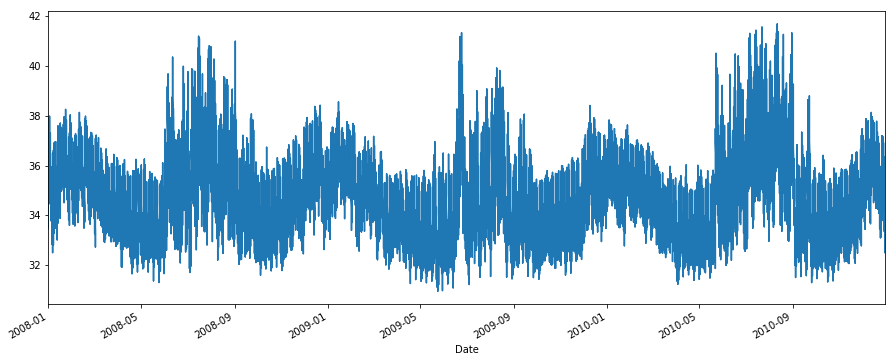

In [23]:
y.plot(figsize=(15, 6),);
#The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the middle(festive season maybe) of the year
# and again low at the end of the year...
#There is always an upward trend within any single year with a couple of low months in the mid of the year...

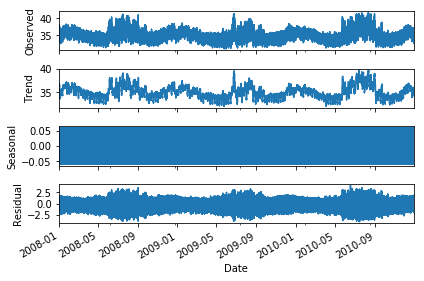

In [24]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='additive',freq=30)
decomposition.plot();
#The plot clearly shows that the sales is unstable, along with its obvious seasonality.;

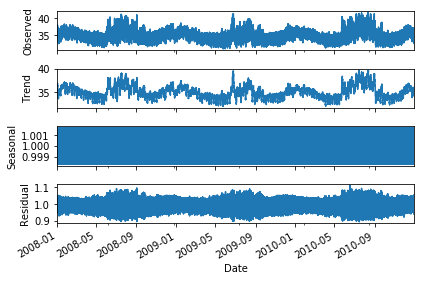

In [25]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',freq=30)
decomposition.plot();
#The plot above clearly shows that the sales is unstable, along with its obvious seasonality.;

## Basic ARIMA

**We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.**

**ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data..**

- AR: Auto-Regressive (p): AR terms are just lags of dependent variable. For example lets say p is 3, we will use x(t-1), x(t-2) and x(t-3) to predict x(t)
- I: Integrated (d): These are the number of nonseasonal differences. For example, in our case we take the first order difference. So we pass that variable and put d=0
- MA: Moving Averages (q): MA terms are lagged forecast errors in prediction equation.

In [26]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


**From the above we cn see that the lags till 50 are having weightage wrt the ACF Plots, but according to the PACF plots they valley out after the 10th lag...**

In [ ]:
cnt = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            cnt += 1
            if cnt % 50 :
                print('Current Iter - {}, ARIMA{}x{} 12 - AIC:{}'.format(cnt, param, param_seasonal, results.aic))
        except:
            continue

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 1, ARIMA(0, 0, 0)x(0, 0, 0, 12) 12 - AIC:261886.91370253958
Current Iter - 2, ARIMA(0, 0, 0)x(0, 0, 1, 12) 12 - AIC:232712.18031385765


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 3, ARIMA(0, 0, 0)x(0, 0, 2, 12) 12 - AIC:198509.38775760066


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 4, ARIMA(0, 0, 0)x(0, 1, 0, 12) 12 - AIC:118037.2027234001


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 5, ARIMA(0, 0, 0)x(0, 1, 1, 12) 12 - AIC:94766.78766931304


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 6, ARIMA(0, 0, 0)x(0, 1, 2, 12) 12 - AIC:89360.46800501246


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 7, ARIMA(0, 0, 0)x(0, 2, 0, 12) 12 - AIC:153292.81213001843


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 8, ARIMA(0, 0, 0)x(0, 2, 1, 12) 12 - AIC:118034.21689831367


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 9, ARIMA(0, 0, 0)x(0, 2, 2, 12) 12 - AIC:94828.22601155745


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 10, ARIMA(0, 0, 0)x(1, 0, 0, 12) 12 - AIC:118015.11542980316


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 11, ARIMA(0, 0, 0)x(1, 0, 1, 12) 12 - AIC:94817.31000116075


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 12, ARIMA(0, 0, 0)x(1, 0, 2, 12) 12 - AIC:95616.12234934219


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 13, ARIMA(0, 0, 0)x(1, 1, 0, 12) 12 - AIC:69969.45398783227


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 14, ARIMA(0, 0, 0)x(1, 1, 1, 12) 12 - AIC:63301.46188835096


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 15, ARIMA(0, 0, 0)x(1, 1, 2, 12) 12 - AIC:61680.21824739935


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 16, ARIMA(0, 0, 0)x(1, 2, 0, 12) 12 - AIC:74459.20765664702


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 17, ARIMA(0, 0, 0)x(1, 2, 1, 12) 12 - AIC:73321.16798285113


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 18, ARIMA(0, 0, 0)x(1, 2, 2, 12) 12 - AIC:63319.686975600394


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 19, ARIMA(0, 0, 0)x(2, 0, 0, 12) 12 - AIC:69969.95362078462


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 20, ARIMA(0, 0, 0)x(2, 0, 1, 12) 12 - AIC:63302.5397471097


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 21, ARIMA(0, 0, 0)x(2, 0, 2, 12) 12 - AIC:61758.153332541006


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 22, ARIMA(0, 0, 0)x(2, 1, 0, 12) 12 - AIC:65371.61648998899


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 23, ARIMA(0, 0, 0)x(2, 1, 1, 12) 12 - AIC:61286.143272682995


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 24, ARIMA(0, 0, 0)x(2, 1, 2, 12) 12 - AIC:61799.13774169059


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 25, ARIMA(0, 0, 0)x(2, 2, 0, 12) 12 - AIC:74013.99663948934


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 26, ARIMA(0, 0, 0)x(2, 2, 1, 12) 12 - AIC:71667.94051827904


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 27, ARIMA(0, 0, 0)x(2, 2, 2, 12) 12 - AIC:61345.66705185281


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 28, ARIMA(0, 0, 1)x(0, 0, 0, 12) 12 - AIC:225569.3958534964


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 29, ARIMA(0, 0, 1)x(0, 0, 1, 12) 12 - AIC:196464.34710073558


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 30, ARIMA(0, 0, 1)x(0, 0, 2, 12) 12 - AIC:181860.60035441976


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 31, ARIMA(0, 0, 1)x(0, 1, 0, 12) 12 - AIC:82395.25988542645


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 32, ARIMA(0, 0, 1)x(0, 1, 1, 12) 12 - AIC:60060.95200492701


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 33, ARIMA(0, 0, 1)x(0, 1, 2, 12) 12 - AIC:54242.18688564573


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 34, ARIMA(0, 0, 1)x(0, 2, 0, 12) 12 - AIC:117584.9480152908


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 35, ARIMA(0, 0, 1)x(0, 2, 1, 12) 12 - AIC:82434.84651685444


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 36, ARIMA(0, 0, 1)x(0, 2, 2, 12) 12 - AIC:60152.47439526043


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 37, ARIMA(0, 0, 1)x(1, 0, 0, 12) 12 - AIC:82378.52768012432


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 38, ARIMA(0, 0, 1)x(1, 0, 1, 12) 12 - AIC:60097.53645059862


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 39, ARIMA(0, 0, 1)x(1, 0, 2, 12) 12 - AIC:54264.35010166623


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 40, ARIMA(0, 0, 1)x(1, 1, 0, 12) 12 - AIC:70300.05991369278


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 41, ARIMA(0, 0, 1)x(1, 1, 1, 12) 12 - AIC:28713.066984698602


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 42, ARIMA(0, 0, 1)x(1, 1, 2, 12) 12 - AIC:27251.381505773214


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 43, ARIMA(0, 0, 1)x(1, 2, 0, 12) 12 - AIC:39734.104300440835


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 44, ARIMA(0, 0, 1)x(1, 2, 1, 12) 12 - AIC:38590.556202988955


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 45, ARIMA(0, 0, 1)x(1, 2, 2, 12) 12 - AIC:28763.31759730932


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 46, ARIMA(0, 0, 1)x(2, 0, 0, 12) 12 - AIC:70431.03828593319


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 47, ARIMA(0, 0, 1)x(2, 0, 1, 12) 12 - AIC:28714.834189131292


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 48, ARIMA(0, 0, 1)x(2, 0, 2, 12) 12 - AIC:27319.54531563301


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 49, ARIMA(0, 0, 1)x(2, 1, 0, 12) 12 - AIC:65709.08056255734


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 51, ARIMA(0, 0, 1)x(2, 1, 2, 12) 12 - AIC:25985.597130475733


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 52, ARIMA(0, 0, 1)x(2, 2, 0, 12) 12 - AIC:39318.77558751753


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 53, ARIMA(0, 0, 1)x(2, 2, 1, 12) 12 - AIC:31004.923765752817


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 54, ARIMA(0, 0, 1)x(2, 2, 2, 12) 12 - AIC:26979.47012922412


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 55, ARIMA(0, 0, 2)x(0, 0, 0, 12) 12 - AIC:189913.07115387658


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 56, ARIMA(0, 0, 2)x(0, 0, 1, 12) 12 - AIC:162005.55750818312


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 57, ARIMA(0, 0, 2)x(0, 0, 2, 12) 12 - AIC:129400.55408959773


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 58, ARIMA(0, 0, 2)x(0, 1, 0, 12) 12 - AIC:51993.377361296916


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 59, ARIMA(0, 0, 2)x(0, 1, 1, 12) 12 - AIC:31106.994644583967


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 60, ARIMA(0, 0, 2)x(0, 1, 2, 12) 12 - AIC:25583.11008107189


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 61, ARIMA(0, 0, 2)x(0, 2, 0, 12) 12 - AIC:86665.01590478755


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 62, ARIMA(0, 0, 2)x(0, 2, 1, 12) 12 - AIC:52056.660601626165


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 63, ARIMA(0, 0, 2)x(0, 2, 2, 12) 12 - AIC:31221.934856765027


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 64, ARIMA(0, 0, 2)x(1, 0, 0, 12) 12 - AIC:51971.7892233368


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 65, ARIMA(0, 0, 2)x(1, 0, 1, 12) 12 - AIC:31132.25876834353


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 66, ARIMA(0, 0, 2)x(1, 0, 2, 12) 12 - AIC:47422.213978099295


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 67, ARIMA(0, 0, 2)x(1, 1, 0, 12) 12 - AIC:8303.280219899178


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 68, ARIMA(0, 0, 2)x(1, 1, 1, 12) 12 - AIC:8775.380178851914


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 69, ARIMA(0, 0, 2)x(1, 1, 2, 12) 12 - AIC:513.4993151968953


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 70, ARIMA(0, 0, 2)x(1, 2, 0, 12) 12 - AIC:40482.991782829704


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 71, ARIMA(0, 0, 2)x(1, 2, 1, 12) 12 - AIC:118714.78399218689


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 72, ARIMA(0, 0, 2)x(1, 2, 2, 12) 12 - AIC:1841.0327487895124


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 73, ARIMA(0, 0, 2)x(2, 0, 0, 12) 12 - AIC:16629.12107108093


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 74, ARIMA(0, 0, 2)x(2, 0, 1, 12) 12 - AIC:5628.9254297527605


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 75, ARIMA(0, 0, 2)x(2, 0, 2, 12) 12 - AIC:40582.70096226296


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 76, ARIMA(0, 0, 2)x(2, 1, 0, 12) 12 - AIC:4233.985603780374


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 77, ARIMA(0, 0, 2)x(2, 1, 1, 12) 12 - AIC:232.80151941943376


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 78, ARIMA(0, 0, 2)x(2, 1, 2, 12) 12 - AIC:-698.9518883398596


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 79, ARIMA(0, 0, 2)x(2, 2, 0, 12) 12 - AIC:40998.99604310309


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 80, ARIMA(0, 0, 2)x(2, 2, 1, 12) 12 - AIC:4344.681556018931


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 81, ARIMA(0, 0, 2)x(2, 2, 2, 12) 12 - AIC:323.93226571273345


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 82, ARIMA(0, 1, 0)x(0, 0, 0, 12) 12 - AIC:26624.651437939745


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 83, ARIMA(0, 1, 0)x(0, 0, 1, 12) 12 - AIC:26224.675704960384


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 84, ARIMA(0, 1, 0)x(0, 0, 2, 12) 12 - AIC:4174.482314805387


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 85, ARIMA(0, 1, 0)x(0, 1, 0, 12) 12 - AIC:49754.232610864354


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 86, ARIMA(0, 1, 0)x(0, 1, 1, 12) 12 - AIC:16616.87116822923


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 87, ARIMA(0, 1, 0)x(0, 1, 2, 12) 12 - AIC:5529.469261331773


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 88, ARIMA(0, 1, 0)x(0, 2, 0, 12) 12 - AIC:85704.92870021512


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 89, ARIMA(0, 1, 0)x(0, 2, 1, 12) 12 - AIC:49807.89702853983


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 90, ARIMA(0, 1, 0)x(0, 2, 2, 12) 12 - AIC:16568.606815438696


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 91, ARIMA(0, 1, 0)x(1, 0, 0, 12) 12 - AIC:25490.74820521471


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 92, ARIMA(0, 1, 0)x(1, 0, 1, 12) 12 - AIC:7793.156427108261


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 93, ARIMA(0, 1, 0)x(1, 0, 2, 12) 12 - AIC:1027.7490721048093


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 94, ARIMA(0, 1, 0)x(1, 1, 0, 12) 12 - AIC:-20802.000618481616


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 95, ARIMA(0, 1, 0)x(1, 1, 1, 12) 12 - AIC:-21130.00625016948


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 96, ARIMA(0, 1, 0)x(1, 1, 2, 12) 12 - AIC:-26779.602533573103


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 97, ARIMA(0, 1, 0)x(1, 2, 0, 12) 12 - AIC:-733.0334413225845


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 98, ARIMA(0, 1, 0)x(1, 2, 1, 12) 12 - AIC:-20685.851824441223


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 99, ARIMA(0, 1, 0)x(1, 2, 2, 12) 12 - AIC:-21026.131707608383


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 101, ARIMA(0, 1, 0)x(2, 0, 1, 12) 12 - AIC:-21668.183676077813


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 102, ARIMA(0, 1, 0)x(2, 0, 2, 12) 12 - AIC:-26774.556589614327


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 103, ARIMA(0, 1, 0)x(2, 1, 0, 12) 12 - AIC:-21005.393422155605


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 104, ARIMA(0, 1, 0)x(2, 1, 1, 12) 12 - AIC:-25356.466432483092


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 105, ARIMA(0, 1, 0)x(2, 1, 2, 12) 12 - AIC:-27103.00176850811


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 106, ARIMA(0, 1, 0)x(2, 2, 0, 12) 12 - AIC:-6371.155822212387


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 107, ARIMA(0, 1, 0)x(2, 2, 1, 12) 12 - AIC:-20889.420753187613


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 108, ARIMA(0, 1, 0)x(2, 2, 2, 12) 12 - AIC:-22356.98736513279


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 109, ARIMA(0, 1, 1)x(0, 0, 0, 12) 12 - AIC:3370.271931888994


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 110, ARIMA(0, 1, 1)x(0, 0, 1, 12) 12 - AIC:3084.1114690174445


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 111, ARIMA(0, 1, 1)x(0, 0, 2, 12) 12 - AIC:-14206.60802751147


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 112, ARIMA(0, 1, 1)x(0, 1, 0, 12) 12 - AIC:25280.162115470805


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 113, ARIMA(0, 1, 1)x(0, 1, 1, 12) 12 - AIC:-5220.85915606499


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 114, ARIMA(0, 1, 1)x(0, 1, 2, 12) 12 - AIC:-15308.03374404967


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 115, ARIMA(0, 1, 1)x(0, 2, 0, 12) 12 - AIC:58942.83497859069


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 116, ARIMA(0, 1, 1)x(0, 2, 1, 12) 12 - AIC:25355.160430755852


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 117, ARIMA(0, 1, 1)x(0, 2, 2, 12) 12 - AIC:-5056.4993475763295


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 118, ARIMA(0, 1, 1)x(1, 0, 0, 12) 12 - AIC:2565.902828653574


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 119, ARIMA(0, 1, 1)x(1, 0, 1, 12) 12 - AIC:-12690.732756726982


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 120, ARIMA(0, 1, 1)x(1, 0, 2, 12) 12 - AIC:-18680.084076844025


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 121, ARIMA(0, 1, 1)x(1, 1, 0, 12) 12 - AIC:-34353.6327847598


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 122, ARIMA(0, 1, 1)x(1, 1, 1, 12) 12 - AIC:-34614.02879401578


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 123, ARIMA(0, 1, 1)x(1, 1, 2, 12) 12 - AIC:-40821.43631629284


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 124, ARIMA(0, 1, 1)x(1, 2, 0, 12) 12 - AIC:-14766.662776507566


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Current Iter - 125, ARIMA(0, 1, 1)x(1, 2, 1, 12) 12 - AIC:-34229.81634254326


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



The above output suggests that SARIMA(2, 0, 1)x(2, 2, 0, 12) yields the lowest AIC value of 17.435499462373613. Therefore we should consider this to be optimal option.
- ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:28.152584128715233
- ARIMA(0, 0, 1)x(2, 2, 0, 12)12 - AIC:21.20352160942468
- ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:18.308712222027623
- ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:18.039431593093965
- ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:17.583895110587616
- ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:17.435499462373613
- ARIMA(2, 0, 2)x(2, 2, 0, 12)12 - AIC:17.473412955915293

In [208]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 0, 2),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4595      0.723     -0.636      0.525      -1.876       0.957
ar.L2         -0.2111      0.580     -0.364      0.716      -1.348       0.926
ma.L1         -1.4818      5.755     -0.257      0.797     -12.762       9.798
ma.L2          0.5067      2.655      0.191      0.849      -4.697       5.710
ar.S.L12      -0.9731      0.012    -81.995      0.000      -0.996      -0.950
ar.S.L24       0.0203      0.008      2.418      0.016       0.004       0.037
sigma2         0.0665      0.411      0.162      0.872      -0.740       0.873


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



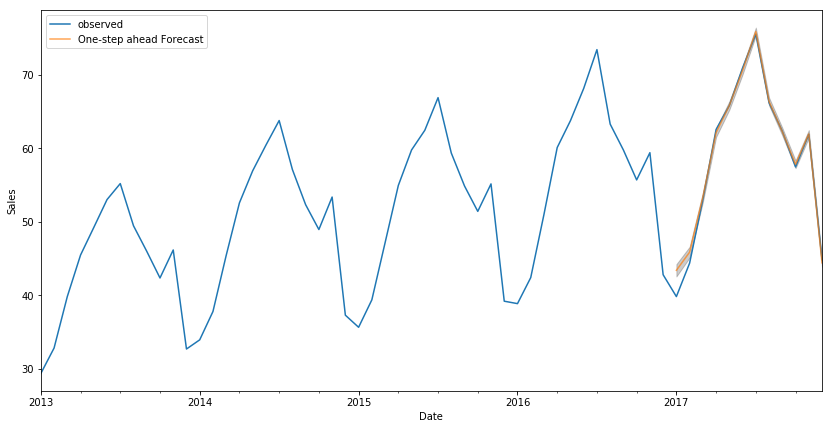

In [209]:
## Validating Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [210]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 3)))
#The MSE is a measure of the quality of an estimator — it is always non-negative, 
#and the smaller the MSE, the closer we are to finding the line of best fit.

The Mean Squared Error of our forecasts is 1.323


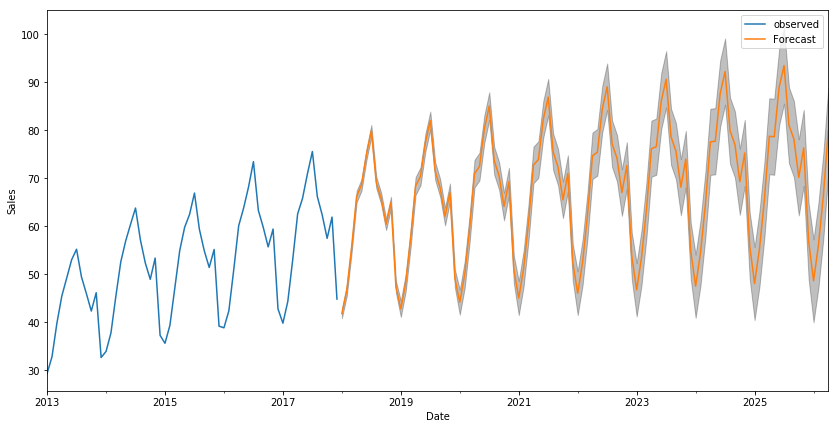

In [188]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [189]:
print('time to here: ', pd.datetime.now() - start_time)

time to here:  0:27:37.342755
